In [1]:
%cd ..

/home/kimsin98/Adolescent/StructFunc


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
idx = pd.IndexSlice
SEED = 69

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks')
colors = sns.color_palette()

In [3]:
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from utils import abcd, plotting, residual

covariates = abcd.load_covariates(covars=['interview_age', 'sex', 'hisp'],
                                  simple_race=True)

In [4]:
fcon, fc_extra = abcd.load_mri_data('fcon', path=abcd.OUT_PATH / 'fcon-device-software.csv')
scon, sc_extra = abcd.load_mri_data('scon', path=abcd.OUT_PATH / 'scon-device-software.csv')

fcon = abcd.filter_siblings(fcon.loc[fcon.index.intersection(scon.index)], random_state=SEED)
fc_extra = fc_extra.loc[fcon.index]
scon, sc_extra = scon.loc[fcon.index], sc_extra.loc[fcon.index]

subs = fcon.index.get_level_values(0).unique()
print(len(subs), 'subjects')

3483 subjects


# Frontoparietal SC-FC

* Wendelken-FrontoparietalStructural-2017

SC tracts
* frontoparietal
    * pSLF: parietal superior longitudinal fasciculus
* intrafrontal
    * IFSFC: inf frontal sup frontal
    * Fmin: forceps minor
* intraparietal

In [5]:
fcon_fo = fcon[abcd.fcon_colname('fo', 'fo')]
scon_pslf = scon[[abcd.scon_colname('pslfrh'), abcd.scon_colname('pslflh')]].mean(axis=1)

In [6]:
# exclude subjects with any outliers (z > 3)
fcon_fo_outliers = fcon_fo.loc[np.abs(stats.zscore(fcon_fo)) > 3]
scon_pslf_outliers = scon_pslf.loc[np.abs(stats.zscore(scon_pslf)) > 3]
subs_noout = (subs.difference(fcon_fo_outliers.index.get_level_values(0))
              .difference(scon_pslf_outliers.index.get_level_values(0)))
print(len(subs_noout), 'subjects')

fcon_fo, scon_pslf = fcon_fo.loc[subs_noout], scon_pslf.loc[subs_noout]

3391 subjects


In [7]:
age = (covariates.loc[fcon_fo.index, 'interview_age'] / 12).rename('age')
age_diff = age.groupby(level=0).diff().dropna().droplevel(1).rename('age_diff')

In [8]:
def stepwise_selection(X, y, groups=None, p_enter=0.1, p_remove=0.3,
                       verbose=True):
    """Forward-backward feature selection with OLS or MixedLM.
    Yoinked from https://datascience.stackexchange.com/a/24447.
    Default p thresholds from R olsrr.ols_step_both_p.
    
    Parameters:
        X: pandas.DataFrame with candidate features
        y: list-like with the target
        groups: columns of random intercepts (use MixedLM)
        p_enter: include if p < p_enter
        p_remove: exclude if p > p_remove
        verbose: print the sequence of inclusions and exclusions
    
    Returns:
        results: final model results
    """
    if p_enter >= p_remove:
        raise ValueError('p_remove must be greater than p_enter to avoid infinite loop')
    
    if groups is not None:
        modelclass = sm.MixedLM
    else:
        modelclass = sm.OLS
    
    included = []
    changed = True
    while changed:
        changed = False
        
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = modelclass(y, sm.add_constant(pd.DataFrame(X[included + [new_column]])),
                               groups=groups)
            new_pval[new_column] = model.fit().pvalues[new_column]
        
        best_pval = new_pval.min()
        if best_pval < p_enter:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:20} with p-value {:.4}'.format(best_feature, best_pval))
        
        # backward step
        model = modelclass(y, sm.add_constant(pd.DataFrame(X[included])),
                           groups=groups)
        pvalues = model.fit().pvalues.iloc[1:] # all coeffs except intercept
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > p_remove:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:20} with p-value {:.4}'.format(worst_feature, worst_pval))
    
    model = modelclass(y, sm.add_constant(pd.DataFrame(X[included])),
                       groups)
    return model.fit()

## Raw Connectivity

### FC, SC change

In [9]:
fcon_fo_age_linregress = stats.linregress(age, fcon_fo)
scon_pslf_age_linregress = stats.linregress(age, scon_pslf)

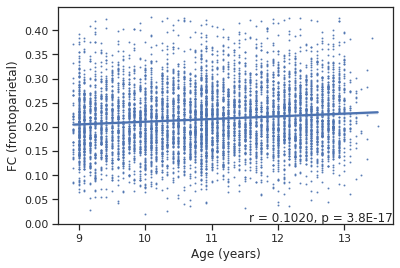

In [10]:
ax = sns.regplot(x=age, y=fcon_fo, scatter_kws={'s': 1})
ax.set_xlabel('Age (years)')
ax.set_ylabel('FC (frontoparietal)')
ax.annotate('r = {r:.4f}, p = {p:.1E}'.format(r=fcon_fo_age_linregress.rvalue,
                                              p=fcon_fo_age_linregress.pvalue),
            xy=(1, 0), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='bottom')
plt.show()

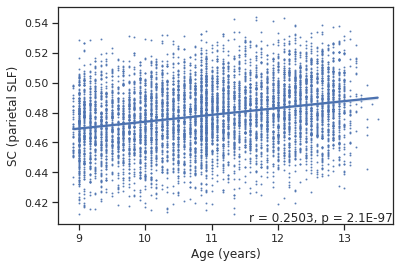

In [11]:
ax = sns.regplot(x=age, y=scon_pslf, scatter_kws={'s': 1})
ax.set_xlabel('Age (years)')
ax.set_ylabel('SC (parietal SLF)')
ax.annotate('r = {r:.4f}, p = {p:.1E}'.format(r=scon_pslf_age_linregress.rvalue,
                                              p=scon_pslf_age_linregress.pvalue),
            xy=(1, 0), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='bottom')
plt.show()

In [12]:
dFC_fo = (fcon_fo.groupby(level=0).diff().dropna().droplevel(1)
          .divide(age_diff))
dSC_pslf = (scon_pslf.groupby(level=0).diff().dropna().droplevel(1)
            .divide(age_diff))

In [13]:
dFC_fo_ttest = stats.ttest_1samp(dFC_fo, 0, alternative='greater')
dSC_pslf_ttest = stats.ttest_1samp(dSC_pslf, 0, alternative='greater')

print('frontoparietal FC change > 0, p = {p:.1E}'.format(p=dFC_fo_ttest[1]))
print('frontoparietal SC change > 0, p = {p:.1E}'.format(p=dSC_pslf_ttest[1]))

frontoparietal FC change > 0, p = 4.1E-25
frontoparietal SC change > 0, p = 0.0E+00


### SC-FC

#### Concurrent

In [14]:
data = (pd.DataFrame({'FC': fcon_fo, 'SC': scon_pslf})
        .join(age).join(age_diff))
groups = data.index.to_frame()[abcd.INDEX[0]]

with warnings.catch_warnings():
    warnings.simplefilter('ignore', sm.tools.sm_exceptions.ConvergenceWarning)
    model = smf.mixedlm('FC ~ SC + age', data, groups=groups)
    results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: FC       
No. Observations: 6782    Method:             REML     
No. Groups:       3391    Scale:              0.0027   
Min. group size:  2       Log-Likelihood:     9231.5069
Max. group size:  2       Converged:          Yes      
Mean group size:  2.0                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.145     0.019  7.687  0.000   0.108   0.182
SC         0.012     0.042  0.299  0.765  -0.069   0.094
age        0.006     0.001  9.711  0.000   0.005   0.007
Group Var  0.001     0.002                              
=======================================================

"""

#### Change

In [15]:
data = (pd.DataFrame({'FC': fcon_fo, 'SC': scon_pslf})
        .join(age).join(age_diff).xs(abcd.EVENTS[0], level=1)
        .join(dFC_fo.rename('dFC')).join(dSC_pslf.rename('dSC')))

results = stepwise_selection(data[['FC', 'SC', 'age', 'age_diff', 'dSC']], data['dFC'],
                             p_enter=0.2, p_remove=0.4)
results.summary()

Add  FC                   with p-value 3.812e-294


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    dFC   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     1649.
Date:                Mon, 30 Aug 2021   Prob (F-statistic):          3.81e-294
Time:                        14:42:02   Log-Likelihood:                 7006.3
No. Observations:                3391   AIC:                        -1.401e+04
Df Residuals:                    3389   BIC:                        -1.400e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0769      0.002     42.531      0.000       0.073       0.080
FC            -0.3356      0.008    -40.610      0.000      -0.352      -0.319
==============================================================================
Omnibus:                       87.097   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.548
Skew:                           0.331   Prob(JB):                     1.20e-23
Kurtosis:                       3.557   Cond. No.                         16.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Residuals

In [16]:
confounds = fc_extra[['meanmotion']].join(covariates[['sex', 'race', 'hisp']])
fcon_fo_r = residual.residuals(fcon_fo, sm.OLS, confounds)

confounds = sc_extra[['meanmotion']].join(covariates[['sex', 'race', 'hisp']])
scon_pslf_r = residual.residuals(scon_pslf, sm.OLS, confounds)

### FC, SC change

In [17]:
fcon_fo_age_linregress = stats.linregress(age, fcon_fo_r)
scon_pslf_age_linregress = stats.linregress(age, scon_pslf_r)

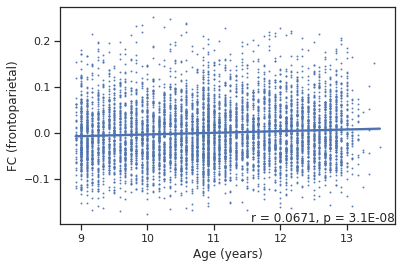

In [18]:
ax = sns.regplot(x=age, y=fcon_fo_r, scatter_kws={'s': 1})
ax.set_xlabel('Age (years)')
ax.set_ylabel('FC (frontoparietal)')
ax.annotate('r = {r:.4f}, p = {p:.1E}'.format(r=fcon_fo_age_linregress.rvalue,
                                              p=fcon_fo_age_linregress.pvalue),
            xy=(1, 0), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='bottom')
plt.show()

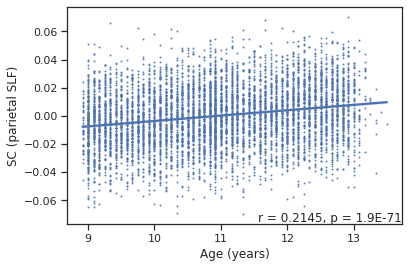

In [19]:
ax = sns.regplot(x=age, y=scon_pslf_r, scatter_kws={'s': 1})
ax.set_xlabel('Age (years)')
ax.set_ylabel('SC (parietal SLF)')
ax.annotate('r = {r:.4f}, p = {p:.1E}'.format(r=scon_pslf_age_linregress.rvalue,
                                              p=scon_pslf_age_linregress.pvalue),
            xy=(1, 0), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='bottom')
plt.show()

In [20]:
dFC_fo = (fcon_fo_r.groupby(level=0).diff().dropna().droplevel(1)
          .divide(age_diff))
dSC_pslf = (scon_pslf_r.groupby(level=0).diff().dropna().droplevel(1)
            .divide(age_diff))

In [21]:
dFC_fo_ttest = stats.ttest_1samp(dFC_fo, 0, alternative='greater')
dSC_pslf_ttest = stats.ttest_1samp(dSC_pslf, 0, alternative='greater')

print('frontoparietal FC change > 0, p = {p:.1E}'.format(p=dFC_fo_ttest[1]))
print('frontoparietal SC change > 0, p = {p:.1E}'.format(p=dSC_pslf_ttest[1]))

frontoparietal FC change > 0, p = 2.0E-12
frontoparietal SC change > 0, p = 0.0E+00


### SC-FC

#### Concurrent

In [22]:
data = (pd.DataFrame({'FC': fcon_fo_r, 'SC': scon_pslf_r})
        .join(age).join(age_diff))
groups = data.index.to_frame()[abcd.INDEX[0]]

with warnings.catch_warnings():
    warnings.simplefilter('ignore', sm.tools.sm_exceptions.ConvergenceWarning)
    model = smf.mixedlm('FC ~ SC + age', data, groups=groups)
    results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: FC       
No. Observations: 6782    Method:             REML     
No. Groups:       3391    Scale:              0.0026   
Min. group size:  2       Log-Likelihood:     9349.7911
Max. group size:  2       Converged:          Yes      
Mean group size:  2.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    -0.044    0.007 -6.717 0.000 -0.057 -0.031
SC           -0.032    0.041 -0.773 0.440 -0.113  0.049
age           0.004    0.001  6.777 0.000  0.003  0.005
Group Var     0.001    0.002                           
=======================================================

"""

#### Change

In [23]:
data = (pd.DataFrame({'FC': fcon_fo_r, 'SC': scon_pslf_r})
        .join(age).join(age_diff).xs(abcd.EVENTS[0], level=1)
        .join(dFC_fo.rename('dFC')).join(dSC_pslf.rename('dSC')))

results = stepwise_selection(data[['FC', 'SC', 'age', 'age_diff', 'dSC']], data['dFC'],
                             p_enter=0.2, p_remove=0.4)
results.summary()

Add  FC                   with p-value 1.674e-305
Add  dSC                  with p-value 0.107


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    dFC   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     865.5
Date:                Mon, 30 Aug 2021   Prob (F-statistic):          2.38e-304
Time:                        14:42:16   Log-Likelihood:                 7061.4
No. Observations:                3391   AIC:                        -1.412e+04
Df Residuals:                    3388   BIC:                        -1.410e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      5.471      0.000       0.002       0.005
FC            -0.3441      0.008    -41.532      0.000      -0.360      -0.328
dSC           -0.1583      0.098     -1.612      0.107      -0.351       0.034
==============================================================================
Omnibus:                      144.023   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.413
Skew:                           0.452   Prob(JB):                     6.67e-40
Kurtosis:                       3.678   Cond. No.                         190.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# SVR with whole SC

* target: Δ frontoparietal connectivity
* features: t0 frontoparietal connectivity, t0 structural connectome, age, sex, race, SC/FC mean motion

In [5]:
fcon_fo = fcon[abcd.fcon_colname('fo', 'fo')]

age = (covariates.loc[fcon_fo.index, 'interview_age'] / 12).rename('age')
age_diff = age.groupby(level=0).diff().dropna().droplevel(1).rename('age_diff')

y = (fcon_fo.groupby(level=0).diff().dropna().droplevel(1)
     .divide(age_diff))

In [6]:
X = (pd.DataFrame(fcon_fo).loc[idx[:, abcd.EVENTS[0]], :]
     .join(scon)
     .join(age)
     .join(covariates['sex'].astype('category'))
     .join(covariates['race'].astype('category'))
     .join(covariates['hisp'].astype('category'))
     .join(fc_extra['meanmotion'].rename('fc_meanmotion'))
     .join(sc_extra['meanmotion'].rename('sc_meanmotion'))
     .droplevel(1))

## Preprocess

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=SEED)

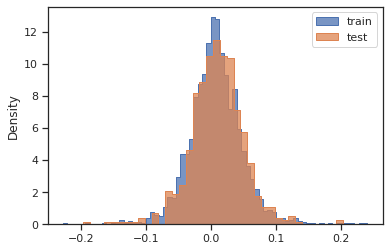

In [8]:
sns.histplot(y_train, label='train', stat='density', element='step', color=colors[0])
sns.histplot(y_test, label='test', stat='density', element='step', color=colors[1])
plt.legend()

plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

preprocess = make_column_transformer(
    (StandardScaler(), X.columns.difference(['sex', 'race', 'hisp'])),
    (OneHotEncoder(), ['sex', 'race', 'hisp']),
    n_jobs=4
)

In [10]:
X_train = preprocess.fit_transform(X_train)
y_train = y_train.to_numpy()

## Model

In [11]:
from sklearn.svm import LinearSVR

l_svr = LinearSVR(loss='epsilon_insensitive', tol=1e-3, max_iter=1e5, random_state=SEED)

In [12]:
from sklearn.model_selection import cross_validate, KFold

cv_l_svr = cross_validate(l_svr, X_train, y_train, scoring=['explained_variance', 'neg_mean_absolute_error'],
                          cv=KFold(), n_jobs=4)

In [13]:
for i, (ev, negmae) in enumerate(zip(cv_l_svr['test_explained_variance'],
                                     cv_l_svr['test_neg_mean_absolute_error'])):
    print('Fold {} -- EV = {:.4f}, MAE = {:.4f}'.format(i+1, ev, -negmae))

Fold 1 -- EV = 0.2248, MAE = 0.0260
Fold 2 -- EV = 0.3756, MAE = 0.0249
Fold 3 -- EV = 0.2796, MAE = 0.0257
Fold 4 -- EV = 0.3252, MAE = 0.0266
Fold 5 -- EV = 0.2964, MAE = 0.0251


In [14]:
X_test = preprocess.transform(X_test)
y_test = y_test.to_numpy()

l_svr.fit(X_train, y_train)
y_pred = l_svr.predict(X_test)

EV:  0.2946000944180778
MAE:  0.026079862119149175


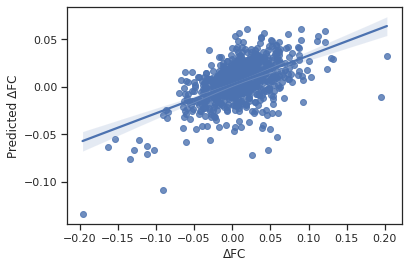

In [15]:
from sklearn.metrics import explained_variance_score, mean_absolute_error

print('EV: ', explained_variance_score(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))

ax = sns.regplot(x=y_test, y=y_pred)
ax.set_xlabel('ΔFC')
ax.set_ylabel('Predicted ΔFC')

plt.show()

## Interpret

In [16]:
features = np.concatenate([
    X.columns[:X.columns.get_loc('sex')],
    preprocess.named_transformers_['onehotencoder'].get_feature_names(),
    X.columns[X.columns.get_loc('hisp') + 1:]
])

In [17]:
coeffs = pd.Series(l_svr.coef_, index=features)

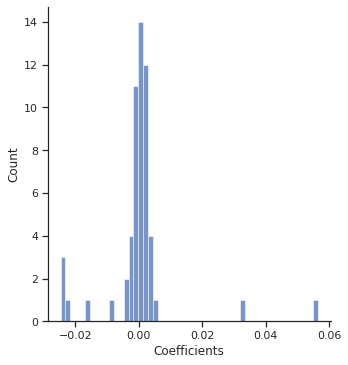

In [18]:
g = sns.displot(coeffs)
g.set_xlabels('Coefficients')

plt.show()

In [19]:
top_coeffs = coeffs.sort_values(ascending=False, key=abs).iloc[:6]
display(top_coeffs)

dmri_dtifa_fiberat_cgcrh        0.056405
dmri_dtifa_fiberat_allfibers    0.032281
dmri_dtifa_fiberat_cghrh       -0.024684
dmri_dtifa_fiberat_cgclh       -0.024350
dmri_dtifa_fiberat_sifcrh      -0.023285
x0_F                           -0.022550
dtype: float64

In [20]:
scon_labels = pd.Series(abcd.get_scon_dict())

scon_labels.loc[top_coeffs.index[top_coeffs.index != 'x0_F']
                .str.replace(abcd.scon_colname(''), '')]

cgcrh                      right cingulate cingulum
allfibers                                all fibers
cghrh                right parahippocampal cingulum
cgclh                       left cingulate cingulum
sifcrh       right striatal inferior frontal cortex
dtype: object

In [21]:
coeffs.abs().rank(ascending=False).loc[[
    abcd.fcon_colname('fo', 'fo'),
    abcd.scon_colname('pslfrh'),
    abcd.scon_colname('pslflh')
]]

rsfmri_c_ngd_fo_ngd_fo       42.0
dmri_dtifa_fiberat_pslfrh    20.0
dmri_dtifa_fiberat_pslflh    35.0
dtype: float64